In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from models.CNN_SE_model import CNN_SE
from models.CNN_model import CNN
from copy import deepcopy
from tqdm import tqdm


In [2]:
data_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

IMAGE_FOLDER = 'images'
# IMAGE_FOLDER = 'images'
dataset = ImageFolder(root=f'./preprocessed-data/{IMAGE_FOLDER}', transform=data_transforms)
print(len(dataset), dataset.classes)
num_of_classes = len(dataset.classes)

20000 ['A300', 'A310', 'A320', 'A330', 'A340', 'A380', 'ATR-42', 'ATR-72', 'Aethia', 'Agelaius', 'Aix', 'Amaurornis', 'An-12', 'Anas', 'Ara', 'Ardeola', 'Asio', 'Aythya', 'BAE 146', 'BAE-125', 'Beechcraft 1900', 'Boeing 707', 'Boeing 717', 'Boeing 727', 'Boeing 737', 'Boeing 747', 'Boeing 757', 'Boeing 767', 'Boeing 777', 'Bucephala', 'Buteo', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700', 'Calidris', 'Callipepla', 'Campylorhynchus', 'Cardinalis', 'Celeus', 'Cessna 172', 'Cessna 208', 'Cessna Citation', 'Challenger 600', 'Charadrius', 'Chrysococcyx', 'Coccothraustes', 'Colaptes', 'Columba', 'Coracias', 'Corvus', 'Coua', 'Cyanocorax', 'Cygnus', 'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6', 'DR-400', 'Dash 8', 'Dendrocitta', 'Dornier 328', 'EMB-120', 'Embraer E-Jet', 'Embraer ERJ 145', 'Embraer Legacy 600', 'Euphonia', 'Euplectes', 'Eurofighter Typhoon', 'Eurylaimus', 'F-16', 'FA-18', 'Falco', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50', 'Fokker 70', 'Global Expr

In [3]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


cuda:0


In [4]:
model_cnn = CNN(num_of_classes).to(device)
model_cnn_se = CNN_SE(num_of_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
optimizer_cnn_se = optim.Adam(model_cnn_se.parameters(), lr=0.001)

best_cnn_acc = -1
best_cnn_se_acc = -1
best_cnn = None
best_cnn_se = None
cnn_acc_record = {'train': [], 'val': []}
cnn_se_acc_record = {'train': [], 'val': []}

In [5]:
def train(epoch):
    model_cnn.train()
    model_cnn_se.train()
    correct_cnn = 0
    correct_cnn_se = 0
    total_ct = 0
    for x,y in train_loader:
        x: torch.Tensor = x.to(device)
        y: torch.Tensor = y.to(device)
        
        optimizer_cnn.zero_grad()
        optimizer_cnn_se.zero_grad()

        assert str(x.device) == str(y.device) == str(device), f"x: {x.device}, y: {y.device}, device: {device}"
        y_hat_cnn = model_cnn(x)
        y_hat_cnn_se = model_cnn_se(x)

        loss_cnn = criterion(y_hat_cnn, y)
        loss_cnn_se = criterion(y_hat_cnn_se, y)

        correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
        correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
        total_ct += y.size(0)

        loss_cnn.backward()
        loss_cnn_se.backward()

        optimizer_cnn.step()
        optimizer_cnn_se.step()

        # print(f"Epoch: {epoch}, CNN loss: {loss_cnn.item()}, CNN-SE loss: {loss_cnn_se.item()}")
        
    cnn_acc = correct_cnn / total_ct
    cnn_se_acc = correct_cnn_se / total_ct

    cnn_acc_record['train'].append(cnn_acc)
    cnn_se_acc_record['train'].append(cnn_se_acc)

    print(f'epoch: {epoch} training accuracy| CNN: {round(cnn_acc, 5)} CNN-SE: {round(cnn_se_acc, 5)}')

In [6]:
def validation(epoch, best_acc, best_model):
    model_cnn.eval()
    model_cnn_se.eval()
    correct_cnn = 0
    correct_cnn_se = 0
    total_ct = 0
    with torch.no_grad():
        for x,y in val_loader:
            x: torch.Tensor = x.to(device)
            y: torch.Tensor = y.to(device)

            y_hat_cnn = model_cnn(x)
            y_hat_cnn_se = model_cnn_se(x)
            correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
            correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
            total_ct += y.size(0)

    cnn_acc = correct_cnn / total_ct
    cnn_se_acc = correct_cnn_se / total_ct

    cnn_acc_record['val'].append(cnn_acc)
    cnn_se_acc_record['val'].append(cnn_se_acc)

    best_cnn_acc, best_cnn_se_acc = best_acc
    best_cnn, best_cnn_se = best_model
    if cnn_acc > best_cnn_acc:
        best_cnn_acc = cnn_acc
        best_cnn = deepcopy(model_cnn.state_dict())
    
    if cnn_se_acc > best_cnn_se_acc:
        best_cnn_se_acc = cnn_se_acc
        best_cnn_se = deepcopy(model_cnn_se.state_dict())
    

    print(f'epoch: {epoch} validation accuracy| CNN: {round(cnn_acc, 5)} CNN-SE: {round(cnn_se_acc, 5)}')
    return (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se)

In [7]:
EPOCHS = 20
for epoch in range(EPOCHS):
    train(epoch)
    (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se) = validation(epoch, (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se))

epoch: 0 training accuracy| CNN: 0.14758 CNN-SE: 0.15458
epoch: 0 validation accuracy| CNN: 0.24275 CNN-SE: 0.19075
epoch: 1 training accuracy| CNN: 0.47842 CNN-SE: 0.48758
epoch: 1 validation accuracy| CNN: 0.37575 CNN-SE: 0.22225
epoch: 2 training accuracy| CNN: 0.90067 CNN-SE: 0.90567
epoch: 2 validation accuracy| CNN: 0.4275 CNN-SE: 0.231
epoch: 3 training accuracy| CNN: 0.99833 CNN-SE: 0.998
epoch: 3 validation accuracy| CNN: 0.46475 CNN-SE: 0.4205
epoch: 4 training accuracy| CNN: 0.99992 CNN-SE: 1.0
epoch: 4 validation accuracy| CNN: 0.467 CNN-SE: 0.44975
epoch: 5 training accuracy| CNN: 1.0 CNN-SE: 1.0
epoch: 5 validation accuracy| CNN: 0.46625 CNN-SE: 0.44775
epoch: 6 training accuracy| CNN: 1.0 CNN-SE: 1.0
epoch: 6 validation accuracy| CNN: 0.46425 CNN-SE: 0.448
epoch: 7 training accuracy| CNN: 1.0 CNN-SE: 1.0
epoch: 7 validation accuracy| CNN: 0.4665 CNN-SE: 0.444
epoch: 8 training accuracy| CNN: 1.0 CNN-SE: 1.0
epoch: 8 validation accuracy| CNN: 0.46725 CNN-SE: 0.44425
epoch

In [10]:
model_cnn.load_state_dict(best_cnn)
model_cnn_se.load_state_dict(best_cnn_se)
model_cnn.eval()
model_cnn_se.eval()
correct_cnn = 0
correct_cnn_se = 0
total_ct = 0
with torch.no_grad():
    for x,y in test_loader:
        x: torch.Tensor = x.to(device)
        y: torch.Tensor = y.to(device)

        y_hat_cnn = model_cnn(x)
        y_hat_cnn_se = model_cnn_se(x)
        correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
        correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
        total_ct += y.size(0)

cnn_acc = correct_cnn / total_ct
cnn_se_acc = correct_cnn_se / total_ct

torch.save(model_cnn, "saved-models/cnn.pt")
torch.save(model_cnn_se, "saved-models/cnn-se.pt")

print(f'test accuracy| CNN: {round(cnn_acc, 5)} CNN-SE: {round(cnn_se_acc, 5)}')


test accuracy| CNN: 0.47125 CNN-SE: 0.458


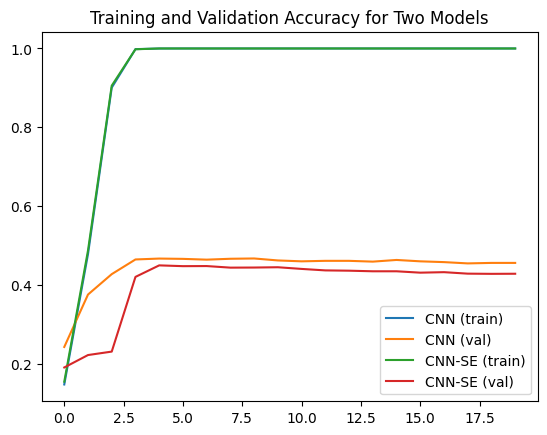

In [11]:
plt.plot(cnn_acc_record['train'], label='CNN (train)')
plt.plot(cnn_acc_record['val'], label='CNN (val)')

plt.plot(cnn_se_acc_record['train'], label='CNN-SE (train)')
plt.plot(cnn_se_acc_record['val'], label='CNN-SE (val)')

plt.title('Training and Validation Accuracy for Two Models')
plt.legend()

plt.show()
